In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFBertForMaskedLM

c:\Users\Kalea\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## cahya/t5-base-indonesian-summarization-cased_summarization_dakwaan
# df = pd.read_csv(f'../Data/STAGE 3 PREPROCESSING/T5 BASE_SINGARAJA_TEST_STAGE_3_PREPROCESSING_20241206_145728.csv')

## panggi/t5-small-indonesian-summarization-cased_summarization_dakwaan
## interstellarx95/mt5-small-finetuned-indonesian-text-summarization-one-epoch_summarization_dakwaan
## interstellarx95/mt5-small-finetuned-indonesian-text-summarization-v3_summarization_dakwaan
## rayendito/mt5-small-finetuned-xl-sum-indonesia_summarization_dakwaan
## interstellarx95/mt5-small-finetuned-indonesian-text-summarization-three-epochs_summarization_dakwaan
# df = pd.read_csv(f'../Data/STAGE 3 PREPROCESSING/T5 2ND_SINGARAJA_TEST_STAGE_3_PREPROCESSING_20241207_001236.csv')

# "cahya/bert2bert-indonesian-summarization",
# "rowjak/bert-indonesian-news-summarization"
# "cahya/bert2gpt-indonesian-summarization",
df = pd.read_csv(f'../Data/STAGE 3 PREPROCESSING/BERT SINGARAJA_TEST_STAGE_3_PREPROCESSING_20241207_122142.csv')


In [3]:
df

,klasifikasi_perkara,terdakwa,hakim,jumlah_saksi,cleaned_barang_bukti,cleaned_dakwaan,total_pidana_penjara_bulan,cahya_bert2bert_summarization_dakwaan,rowjak/bert-indonesian-news-summarization,cahya_bert2gpt_summarization_dakwaan
0,Kejahatan Perjudian,KETUT SUBAGIA,I Made Bagiarta,3,1 (satu) buah papan bola bergambar 1 (satu) bu...,DAKWAAN PERTAMA - Bahwa Terdakwa KETUT SUBA...,4,dakwaan pertama - kedua terdakwa ketut subagia...,dakwaan pertama - kedua terdakwa ketut subagia...,dakwaan pertama - bahwa terdakwa ketut subagia...
1,Kejahatan Perjudian,KOMANG ADITYA,I Made Bagiarta,3,1 (satu) buah papan bola bergambar 1 (satu) bu...,DAKWAAN PERTAMA - Bahwa Terdakwa KETUT SUBA...,4,dakwaan pertama - kedua terdakwa ketut subagia...,dakwaan pertama - kedua terdakwa ketut subagia...,dakwaan pertama - bahwa terdakwa ketut subuku ...
2,Narkotika,I NYOMAN SUARTA,I Made Bagiarta,3,38 (tiga puluh delapan) potongan pipet plastik...,DAKWAAN KESATU Bahwa ia Terdakwa...,52,dakwaan kesatu bahwa ia terdakwa i nyoman suar...,dakwaan kesatu bahwa ia terdakwa i nyoman suar...,dakwaan kesatu bahwa terdakwa i nyoman suarta ...
3,Narkotika,RICO JAYADI,I Made Bagiarta,3,1 (satu) buah dompet warna hijau 20 (dua puluh...,DAKWAAN KESATU ...,72,dakwaan kesatu bahwa ia terdakwa rico jayadi p...,dakwaan kesatu bahwa ia terdakwa rico jayadi p...,dakwaan kesatu bahwa ia terdakwa rico jayadi p...
4,Narkotika,SANG PUTU WIDIANA,I Gusti Made Juliartawan,4,1(satu) buah HP merk Realme warna hitam putih,Dakwaan Ke Satu - Bahwa terdakwa SANG PUTU W...,48,dakwaan ke satu - satunya tentang terdakwa san...,dakwaan ke satu - satunya ditujukan terhadap t...,dakwaan terhadap terdakwa sang putu widiana be...
...,...,...,...,...,...,...,...,...,...,...
1191,Perlindungan dan Pengelolaan Lingkungan Hidup,Jumat Ariyanto,Ida Bagus Bama Dewa. P,3,1 (satu) 1 (satu) batang kayu balang-balang be...,Kesatu Pasal 83 ayat (1) huruf b UU RI No. 18...,12,kesatu pasal 83 ayat ( 1 ) huruf b uu ri no. 1...,dua pasal dalam uu ri nomor 18 tahun 2013 tent...,kesatu pasal 83 ayat ( 1 ) huruf b undang - un...
1192,Kejahatan Perjudian,I KETUT ANA SAPUTRA Alias BENCUT,Sudar,1,36 (tiga puluh enam) lembar kertas rekapan,Perbuatan terdakwa sebagaimana diatur dan dian...,4,perbuatan terdakwa sebagaimana diatur dan dian...,terdakwa kasus penyekapan perjudian didakwa pa...,perbuatan terdakwa sebagaimana diatur dan dian...
1193,Penganiayaan,Sahabudin Alias Udin,Ni Luh Suantini,2,1. 1 (satu) buah tabung gas elpiji ukuran 3 (t...,Pasal 351 ayat (1) Kitab Undang-undang Hukum p...,9,pasal 351 ayat 1 kitab undang - undang hukum p...,kasak kusario ayat ( 1 ) menyebutkan pasal 351...,"pasal 351 ayat ( 1 / 1 ), undang - undang huku..."
1194,Kejahatan yang Membahayakan Keamananan Umum Ba...,Putu Kristian Damanta,A.A. Sagung Yuni Wulantrisna,4,-1 (satu)unit sepeda motor merk Yamaha Jupiter...,Pertama Pasal 187 ayat (1) KUHP dan Kedua Pa...,24,kabar buruk bagi guus hiddink. dua gol yang di...,satu lagi kado tak menyenangkan bagi tom hiyos...,"akhir pekan ke - 25, jumat dinihari ( wib ), b..."


In [4]:
df.columns

Index(['klasifikasi_perkara', 'terdakwa', 'hakim', 'jumlah_saksi',
       'cleaned_barang_bukti', 'cleaned_dakwaan', 'total_pidana_penjara_bulan',
       'cahya_bert2bert_summarization_dakwaan',
       'rowjak/bert-indonesian-news-summarization',
       'cahya_bert2gpt_summarization_dakwaan'],
      dtype='object')

In [5]:
# use_summarize = "cahya/t5-base-indonesian-summarization-cased_summarization_dakwaan"
# use_summarize = "panggi/t5-small-indonesian-summarization-cased_summarization_dakwaan"
# use_summarize = "interstellarx95/mt5-small-finetuned-indonesian-text-summarization-one-epoch_summarization_dakwaan"
# use_summarize = "interstellarx95/mt5-small-finetuned-indonesian-text-summarization-v3_summarization_dakwaan"
# use_summarize = "rayendito/mt5-small-finetuned-xl-sum-indonesia_summarization_dakwaan"
# use_summarize = "interstellarx95/mt5-small-finetuned-indonesian-text-summarization-three-epochs_summarization_dakwaan"
# use_summarize = "cahya/bert2bert-indonesian-summarization"
# use_summarize = "rowjak/bert-indonesian-news-summarization"
# use_summarize = "cahya/bert2gpt-indonesian-summarization"
use_summarize = "cleaned_dakwaan"



In [6]:
# # SINGLE DATA SUM
# # Drop the 'cleaned_dakwaan' column
# df = df.drop(columns=['cleaned_dakwaan'])

# # Rename the column
# df = df.rename(columns={
#     'cahya/t5-base-indonesian-summarization-cased_summarization_dakwaan': 'summarized_dakwaan'
# })

# # Print updated DataFrame
# print(df.columns)


In [7]:
# Drop the 'cleaned_dakwaan' column
column_list = [
    'klasifikasi_perkara',
    'terdakwa',
    'hakim',
    'jumlah_saksi',
    'cleaned_barang_bukti',
    'total_pidana_penjara_bulan',
    'cleaned_dakwaan'
    # 'cahya_bert2gpt_summarization_dakwaan'
]

df_copy = df[column_list]
# Rename the column
# df_copy = df_copy.rename(columns={
#     'cahya_bert2gpt_summarization_dakwaan': 'summarized_dakwaan'
# })

# Print updated DataFrame
print(df_copy.columns)


Index(['klasifikasi_perkara', 'terdakwa', 'hakim', 'jumlah_saksi',
       'cleaned_barang_bukti', 'total_pidana_penjara_bulan',
       'cleaned_dakwaan'],
      dtype='object')


In [8]:
print(df_copy.columns)

Index(['klasifikasi_perkara', 'terdakwa', 'hakim', 'jumlah_saksi',
       'cleaned_barang_bukti', 'total_pidana_penjara_bulan',
       'cleaned_dakwaan'],
      dtype='object')


In [9]:
# Use all columns except 'total_pidana_penjara_bulan' as features and set it as the target
X = df_copy.drop(columns=['total_pidana_penjara_bulan'])
y = df_copy['total_pidana_penjara_bulan']

# Train-test split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

In [11]:
# Tokenize each feature column independently
def tokenize_features(features_df, tokenizer, max_len=128):
    tokenized_data = {}
    for column in features_df.columns:
        encodings = tokenizer(
            features_df[column].astype(str).tolist(),
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="tf",
        )
        tokenized_data[f"{column}_input_ids"] = encodings["input_ids"]
        tokenized_data[f"{column}_attention_mask"] = encodings["attention_mask"]
    return tokenized_data

In [12]:
train_tokenized = tokenize_features(train_X, tokenizer)
val_tokenized = tokenize_features(val_X, tokenizer)

In [13]:
train_y = tf.convert_to_tensor(train_y.values, dtype=tf.float32)
val_y = tf.convert_to_tensor(val_y.values, dtype=tf.float32)

In [14]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_tokenized, train_y)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((val_tokenized, val_y)).batch(16)

In [15]:
# Define BERT-based model
bert_model = TFBertForMaskedLM.from_pretrained('indolem/indobert-base-uncased', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [16]:
# Freeze the BERT layers if you don't want to fine-tune them
for layer in bert_model.layers:
    layer.trainable = False


In [17]:
# Process each feature through BERT
feature_inputs = {}
bert_outputs = []
for column in train_X.columns:
    # Create input layers for input_ids and attention_mask
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name=f"{column}_input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name=f"{column}_attention_mask")
    
    # Pass through BERT model
    bert_output = bert_model(input_ids, attention_mask=attention_mask)
    
    # BERT output contains multiple items, where the first is the last hidden state
    last_hidden_state = bert_output[0]  # This is the last_hidden_state
    
    # Apply pooling to get a fixed-length representation of the sequence
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state)
    
    # Store the input layers and outputs
    feature_inputs[f"{column}_input_ids"] = input_ids
    feature_inputs[f"{column}_attention_mask"] = attention_mask
    bert_outputs.append(pooled_output)

In [18]:
# Concatenate BERT outputs from all features
concatenated_features = tf.keras.layers.Concatenate()(bert_outputs)

# Add a regression head
output = tf.keras.layers.Dense(1, activation="linear")(concatenated_features)

# Build the model
model = tf.keras.Model(inputs=feature_inputs, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
60/60 [==============================] - 155s 2s/step - loss: 1358.7228 - mae: 21.3954 - val_loss: 722.5572 - val_mae: 21.9965
Epoch 2/20
60/60 [==============================] - 107s 2s/step - loss: 1277.8352 - mae: 20.3194 - val_loss: 709.4514 - val_mae: 21.8203
Epoch 3/20
60/60 [==============================] - 108s 2s/step - loss: 1232.1709 - mae: 19.8414 - val_loss: 681.0744 - val_mae: 20.8865
Epoch 4/20
60/60 [==============================] - 107s 2s/step - loss: 1258.5946 - mae: 20.3005 - val_loss: 661.0689 - val_mae: 20.1173
Epoch 5/20
60/60 [==============================] - 107s 2s/step - loss: 1221.0898 - mae: 19.8850 - val_loss: 715.0857 - val_mae: 21.5324
Epoch 6/20
60/60 [==============================] - 107s 2s/step - loss: 1216.0513 - mae: 20.0117 - val_loss: 642.8393 - val_mae: 19.3675
Epoch 7/20
60/60 [==============================] - 107s 2s/step - loss: 1175.7537 - mae: 19.4090 - val_loss: 685.5312 - val_mae: 20.4562
Epoch 8/20
60/60 [================

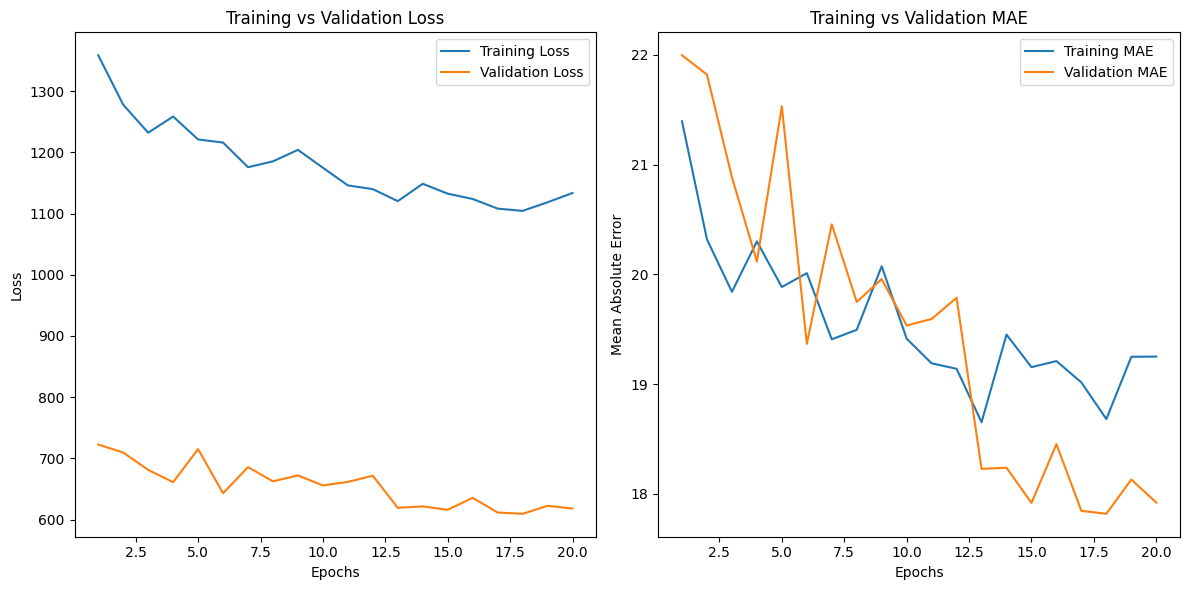

In [20]:
import matplotlib.pyplot as plt

# Get the training and validation metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [21]:
# Tokenize the new data (you can use the same tokenizer as in training)
actual_sentence = y.iloc[0:1].values
new_data = X.iloc[0:1]  # Extracting the first row (1 row, hence 0:1)

new_tokenized = tokenize_features(new_data, tokenizer)

# Make predictions using the trained model
predictions = model.predict(new_tokenized)

print(f"Actual Kurungan Penjara: {actual_sentence}")
print(f"Predicted Kurungan Penjara: {predictions}")

1/1 [==============================] - 11s 11s/step
Actual Kurungan Penjara: [4]
Predicted Kurungan Penjara: [[34.993732]]


In [21]:
actual_sentence

array([4], dtype=int64)